# QR Factorization

## Assignment description

*The central program computes a QR factorization of a matrix A, where Q is the product of several orthogonal matrices but is never itself computed There should be separate programs to compute the individual transformations and the result of applying them row-wise ( you can think of it as a column-wise factorization of transpose of A). Another program should use the QR factors to compute solutions of linear least squares problems. The latter requires a program to perform back-substitution, which should be done row-wise. Do not assume that A has full column rank;*

$$
\begin{aligned}
A \vec{x} = \vec{b} \\ \\
A = Q R \implies R\vec{x} = Q^\top \vec{b} \\
\end{aligned}
$$

### Rank Deficient QR

If A does not have full rank then $\hat{R}$ is singular since one of it's diagonal entries $r_{11}, ... , r_{mm}$ is 0. We need to make use of column pivoting with the standard QR algorith. Zero pivots will be moved to the lower right hand corner of $\hat{R}$ 



Where $\hat{A}$ is $A$ with permuted columns, $R_{11} \in \mathbb{R}^{r\times r}$ is nonsingular and upper triangular, and

The basic algorithm for rank deficient QR with householder transformations is

for i in [1,m]:
  - Compute $ \| \vec{a}_{j, i:m} \|_2 \space \forall j \in [i,m] $, that is the 2-norm for every column in the submatrix $A_{i:n,i:m}$
    - Let $ \| \vec{a}_{k,i:n}\|_2$ be the maximum computed 2-norm
    - Swap $\vec{a_i}$ and $\vec{a_k}$ via permuation matrix $P_{ik}$
      - $\hat{A} = A P_{ik}$
    - Compute $Q_i = I - 2\vec{u}\vec{u}^T$
      - $\vec{v} = \vec{a}_{k, i:n} - (-sign(\vec{a}_{k,1})) * (\| \vec{a}_{k, i:n} \|_2 )* \vec{e}_{i,i:n}$
      - $\vec{u} = \frac{\vec{v}}{\| \vec{v} \|_2}$
    - Apply $Q_i$ transformation to $A_{i:n,i:m}$ to transform the first column to $[r_i, 0, ... , 0]^T$ 
$$
\begin{aligned}
Q_rQ_{r-1}...Q_{1}\hat{A} = 

\begin{bmatrix}
R_{11} & R_{12} \\
0 & 0
\end{bmatrix}	

= R \\ \\
\implies \hat{A} = QR
\end{aligned}
$$


### Applying to least squares problem

After QR we have matrix $\hat{A}$ which is permuted $A$, therefore we apply the same permuation to $\vec{x} \implies \hat{\vec{x}} = P\vec{x}$

We then have the system $\hat{A} \hat{\vec{x}} = b \implies R\hat{\vec{x}} = Q^T\vec{b} = \vec{c}$

$$
\begin{aligned}

\begin{bmatrix}
R_{11} & R_{12} \\
0 & 0
\end{bmatrix}	

\begin{bmatrix}
\hat{\vec{x_1}} \\
\hat{x_2}
\end{bmatrix}

= 

\begin{bmatrix}
\hat{\vec{c}} \\
\vec{d}
\end{bmatrix}

\end{aligned}
$$

The residual for this system is then

$$
\begin{aligned}

\vec{s} = \begin{bmatrix}
\hat{\vec{c}} - R_{11}\hat{\vec{x_1}}  - R_{12}\hat{\vec{x_2}} \\
\vec{d} 
\end{bmatrix}	\\ \\

\end{aligned}
$$

Where the error is then

$$
\begin{aligned}

\| \vec{s} \|_2  = \sqrt{ \| \hat{\vec{c}} - R_{11}\hat{\vec{x_1}} - R_{12}\hat{\vec{x_2}} \|^2_2 + \| \vec{d} \|^2_2 }

\end{aligned}

$$

We minimize the error in the least squares problem, therefore

$$
\begin{aligned}

\hat{\vec{x}} = 

\begin{bmatrix}
\hat{\vec{x_1}} \\
\hat{x_2}
\end{bmatrix}

=  \argmin_{\vec{x}} \| \hat{A} \vec{x} - \vec{b} \|_2

\iff  

\hat{\vec{x}} = \argmin_{\vec{x}} \| Q^T\vec{b} - R_{11}\vec{x_1} - R_{12}\vec{x_2} \|_2 

\end{aligned}
$$

In [2]:
import numpy as np
import pynla as nla
from matplotlib import pyplot as plt

def dump_matrix(M):
  n,m = np.shape(M)
  for y in range(n):
    for x in range(m):
      print(M[y,x], end=' ')
    print()
  print()

In [ ]:
def swap_col(A, c_1, c_2):
  A[:, [c_1, c_2]] = A[:, [c_2, c_1]]
  return A


'''
Apply a series of householder transformations to get

c = Q.T * b

'''
def householder_transform(b, H):
  c = b.copy()
  for h in reversed(H):
    if h is None:
      continue
    v,i = h
    c[i:] -= 2 * v * np.dot(v, c[i:])

  return c

def QRFactorize(A):
  n, m = np.shape(A)
  P = np.arange(m)
  R = A.copy().astype(float)
  H = []

  # for each column
  for i in range(min(m,n)):

    # Compute 2-norm of every column in submatrix A[i::n, i::m]
    # Get the maximum 2-norm computed A[k], swap that column with column A[i]
    # THIS CAN BE IMPROVED
    k = i
    max_norm = np.linalg.norm(R[i:n, k])
    for j in range(i+1, m):
      norm = np.linalg.norm(R[i:n, j])
      if norm > max_norm:
        k = j
        max_norm = norm

    R = swap_col(R, i, k)
    P[[i, k]] = P[[k, i]]

    a = R[i:, i].copy()

    sign = -1 if a[0] < 0 else 1

    a[0] += sign * np.linalg.norm(a)

    u = a / np.linalg.norm(a)

    R[i:, i:] -= 2 * np.outer(u, u @ R[i:, i:])

    H.append((u,i))

  return R, P, H

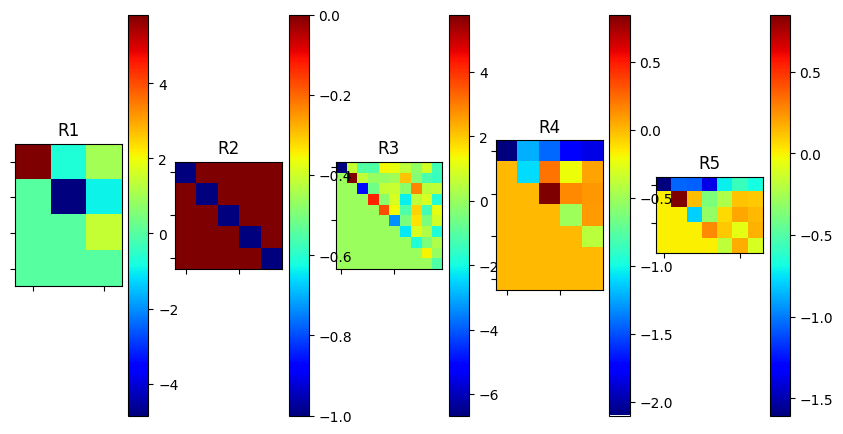

In [26]:
A = np.array([[1,-1,4], [1,4,-2], [1,4,2], [1,-1,0]])
R1, P1, H1 = QRFactorize(A)

B = np.eye(5)
R2, P2, H2 = QRFactorize(B)

A_spd = nla.create_pd_matrix(10, v_range=[0.1,10])
R3, P3, H3 = QRFactorize(A_spd)

A_rand = np.random.rand(7,5)
R4, P4, H4 = QRFactorize(A_rand)

A_rand2 = np.random.rand(5,7)
R5, P5, H5 = QRFactorize(A_rand2)

figure, axis = plt.subplots(1, 5, figsize=(10,10))
axis[0].set_title("R1")
axis[0].set_xticklabels([])
axis[0].set_yticklabels([])
plt.colorbar(axis[0].imshow(R1, cmap='jet'), ax=axis[0])

axis[1].set_title("R2")
axis[1].set_xticklabels([])
axis[1].set_yticklabels([])
plt.colorbar(axis[1].imshow(R2, cmap='jet'), ax=axis[1])

axis[2].set_title("R3")
axis[2].set_xticklabels([])
axis[2].set_yticklabels([])
plt.colorbar(axis[2].imshow(R3, cmap='jet'), ax=axis[2])

axis[3].set_title("R4")
axis[3].set_xticklabels([])
axis[3].set_yticklabels([])
plt.colorbar(axis[3].imshow(R4, cmap='jet'), ax=axis[3])

axis[4].set_title("R5")
axis[4].set_xticklabels([])
axis[4].set_yticklabels([])
plt.colorbar(axis[4].imshow(R5, cmap='jet'), ax=axis[4])

3.156456 1.1397331 2.4911494 -0.43060666 -0.13017166 1.4173628 -0.09115967 -1.3787949 -0.8449735 -1.5991429 
0.6391667 2.057222 0.025790066 1.7613816 -0.16804472 0.8347578 -0.04215008 -0.89913726 0.9660068 -0.0031793974 
1.1957687 -0.51400554 5.05795 1.536786 0.77382827 1.2647394 -0.87114835 1.2011443 -1.5146754 0.3646677 
1.6293235 -1.1514468 -1.0883795 3.3307805 -0.70272875 0.32063267 1.458185 -1.0720552 0.86051124 -0.43080652 
0.46439457 1.1019973 1.0459573 -0.2210692 4.094389 -0.3885315 -0.2686521 -0.17372487 -0.24971752 0.6702138 
0.9388587 -0.14528036 2.7282362 0.6737114 -0.501971 3.6617203 1.2255433 0.45652467 -0.6987034 0.73255897 
-0.8595444 -0.86983097 -0.1250073 -0.4702986 0.09876416 0.24660492 4.3197117 -0.45390224 -0.07457964 1.2794193 
1.3680913 -0.41253293 0.36364087 -0.6424922 0.39353406 -0.7858762 -0.6677067 5.7377014 -3.0677116 1.2502571 
-0.86411816 -1.1697401 -1.6485789 0.9847992 0.10810827 -0.41274297 0.16907488 -1.1215785 3.8637176 0.5107078 
-0.06622946 -0.056314